# Permutation Feature-based Frequency Response Analysis
## A brief tutorial for PFFRA

In [1]:
import PFFRA
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

#### Generate synthetic data for regression

In [2]:
# Generate a simple synthetic dataset
t = np.linspace(0,10, 1000)
x1 = np.sin(2 * np.pi * 10 * t)
x2 = np.sin(2 * np.pi * 20 * t)
x3 = np.cos(2* np.pi * 50 * t)

X = np.vstack((x1, x2, x3)).T
y = 2*x1+x2+0.5*x3

#### Train a XGBM model and generate predictions

In [3]:
model = XGBRegressor(n_estimators = 100)
model = model.fit(X, y)
y_hat = model.predict(X)

#### Plot predictions

Text(0.5, 1.0, 'XGBM predicted time series')

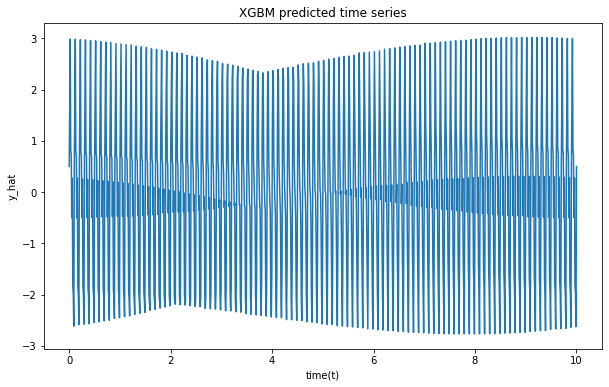

In [4]:
plt.figure(figsize = (10, 6))
plt.plot(t, y_hat)
plt.xlabel("time(t)")
plt.ylabel("y_hat")
plt.title("XGBM predicted time series")

#### Apply PFFRA
##### Draw spectrum figures directly for a given interested feature index
By instantiating class **PermFeatureFreqRespoAnalysis** to specify the feature index as 1, we are able to call **show()** to draw the graph that compares the spectrums with the feature $x_1$ and other features are permuted by thier mean values. The lower subfigure shows the frequency response using the original dataset with all features. 

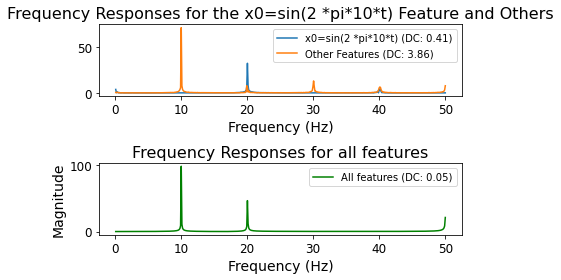

In [5]:
pffra = PFFRA.PermFeatureFreqRespoAnalysis(y = y, X = X, model = model, 
                                           interested_feature_index = 1, sample_rate=100)
pffra.show(rename_feature = "x0=sin(2 *pi*10*t)")

##### Investigate multiple features and output their permutation spectrum data
Calling **gen_spectrum()** method allows us to get access to the spectrum data for any feature.

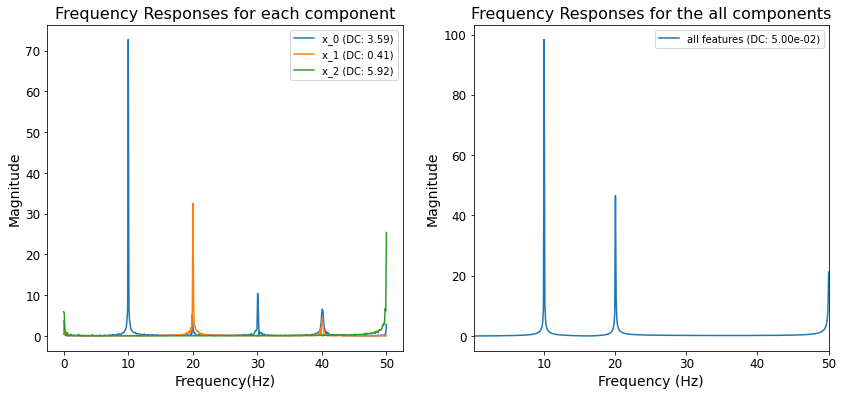

In [6]:
fig = plt.figure(figsize = (14,6))
ax1 = fig.add_subplot(121)
for i in range(X.shape[1]):
    pffra = PFFRA.PermFeatureFreqRespoAnalysis(y = y, X = X, model = model, 
                                               interested_feature_index = i, sample_rate=100)
    spectrum_interested_i, spectrum_other_i, spectrum_all, frq_range = pffra.gen_spectrum()
    plt.rcParams["axes.labelsize"] = 14
    plt.rcParams["axes.titlesize"] = 16  
    plt.rcParams["xtick.labelsize"] = "large"
    plt.rcParams["ytick.labelsize"] = "large"
    ax1.plot(frq_range, spectrum_interested_i, 
             label = "x_{} (DC: {:.2f})".format(i, spectrum_interested_i[0]))
    ax1.legend()
    ax1.set_xlabel("Frequency(Hz)")
    ax1.set_ylabel("Magnitude")
    ax1.set_title("Frequency Responses for each component")

ax2 = fig.add_subplot(122)
ax2.plot(frq_range[1:], spectrum_all[1:], 
         label = "{} (DC: {:.2e})".format("all features", spectrum_all[0]))
ax2.legend()
ax2.set_xlim(frq_range[1], frq_range[-1])
ax2.set_xlabel("Frequency (Hz)")
ax2.set_ylabel("Magnitude")
ax2.set_title("Frequency Responses for the all components")
plt.show()